## Experiment 9
## Network Visualisation: Saliency maps, Class Visualisation

**Saliency maps**

Like class activation maps, a saliency map is a technique to learn information on what parts of the image a model is concentrating on when it makes its predictions. 
- In saliency maps, we are trying to see the relevant pixels. 
- Saliency maps can be generated by computing the gradient of the loss function with respect to the image pixels. 
- Changes in certain pixels that strongly affect the loss function will be shown brightly in the saliency map. 



In [ ]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Build the model

A classifier is built, by using the Inception V3 model available in [Tensorflow Hub](https://tfhub.dev/google/tf2-preview/inception_v3/classification/4). This model has pre-trained weights that is able to detect 1001 classes. 

In [ ]:
# get the model from Tensorflow hub and add a softmax activation at the end for class probabilities
model = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/inception_v3/classification/4'),
    tf.keras.layers.Activation('softmax')
])

# build the model based on a specified batch input shape
model.build([None, 300, 300, 3])

## Get a sample image

The following code downloads a photo of a 'german shepherd' dog that we want the  model to classify. 

In [ ]:
!wget -O image.jpg https://www.kimballstock.com/pix/ani/p/04/dog-01-rk0420-04p.jpg

--2022-07-05 15:30:11--  https://www.kimballstock.com/pix/ani/p/04/dog-01-rk0420-04p.jpg
Resolving www.kimballstock.com (www.kimballstock.com)... 216.47.168.91
Connecting to www.kimballstock.com (www.kimballstock.com)|216.47.168.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82391 (80K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]  80.46K  --.-KB/s    in 0.03s   

2022-07-05 15:30:11 (2.51 MB/s) - ‘image.jpg’ saved [82391/82391]



## Preprocess the image

The image needs to be preprocessed before being fed to the model. This is done in the following steps:

In [ ]:
# read the image
img = cv2.imread('image.jpg')

# format it to be in the RGB colorspace
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

# resize to 300x300 and normalize pixel values to be in the range [0, 1]
img = cv2.resize(img, (300, 300)) / 255.0

# add a batch dimension in front
image = np.expand_dims(img, axis=0)

The following code displays the input image after preprocessing

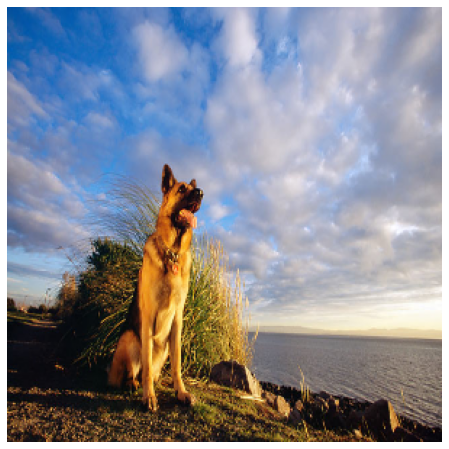

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
exp_output = tf.one_hot(2, 5)
exp_output

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 1., 0., 0.], dtype=float32)>

## Compute Gradients

Gradients of the loss with respect to the input image pixels need to be computed to generate the saliency map.

In [ ]:
# German Shepherd's class ID in ImageNet
class_index = 235   

# If you downloaded the cat, use this line instead
#class_index = 282   # Tabby Cat in ImageNet

# number of classes in the model's training data
num_classes = 1001

# convert to one hot representation to match our softmax activation in the model definition
expected_output = tf.one_hot([class_index] * image.shape[0], num_classes)

with tf.GradientTape() as tape:
    # cast image to float
    inputs = tf.cast(image, tf.float32)

    # watch the input pixels
    tape.watch(inputs)

    # generate the predictions
    predictions = model(inputs)

    # get the loss
    loss = tf.keras.losses.categorical_crossentropy(
        expected_output, predictions
    )

# get the gradient with respect to the inputs
gradients = tape.gradient(loss, inputs)

In [ ]:
image.shape

(1, 300, 300, 3)

In [ ]:
gradients.shape

TensorShape([1, 300, 300, 3])

## Visualize the results

Postprocessing the gradients to generate the saliency maps and overlay it on the image.

In [ ]:
# reduce the RGB image to grayscale
grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)
print(grayscale_tensor.shape)

# normalize the pixel values to be in the range [0, 255].
# the max value in the grayscale tensor will be pushed to 255.
# the min value will be pushed to 0.
normalized_tensor = tf.cast(
    255
    * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,
)

# remove the channel dimension to make the tensor a 2d tensor
normalized_tensor = tf.squeeze(normalized_tensor)

(1, 300, 300)


In [ ]:
# max and min value in the grayscale tensor
print(np.max(grayscale_tensor[0]))
print(np.min(grayscale_tensor[0]))




2.1741784
0.0


The white pixels in the figure plotted below show the parts the model focused on when classifying the image.

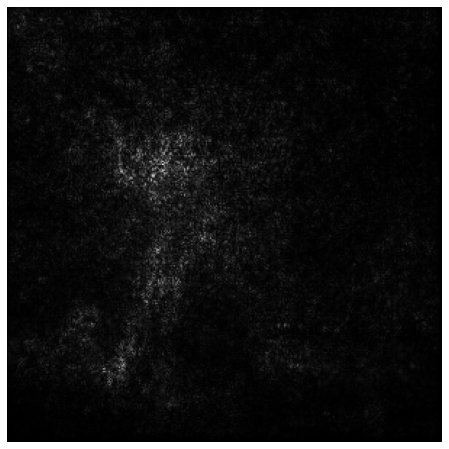

In [ ]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(normalized_tensor, cmap='gray')
plt.show()

The figure plotted below superimposes the normalized tensor onto the input. It can be used to verify that the strong pixels are over the object of interest; this is a good indication that the model is looking at the correct part of the image.

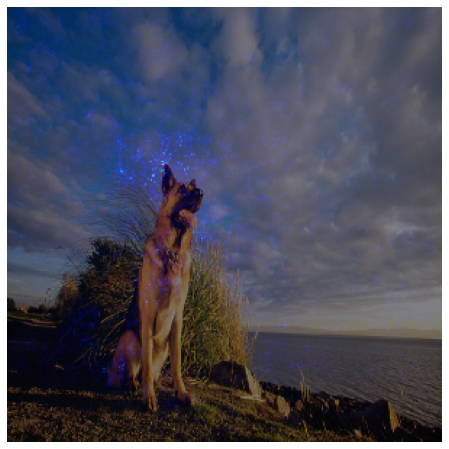

In [ ]:
gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
gradient_color = gradient_color / 255.0
super_imposed = cv2.addWeighted(img, 0.5, gradient_color, 0.5, 0.0)

plt.figure(figsize=(8, 8))
plt.imshow(super_imposed)
plt.axis('off')
plt.show()